In [1]:
import av

import tensorflow as tf

import keras
from keras import layers
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam

import shutil
import imghdr
from PIL import Image

import os
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt

import tempfile
import tensorflow_model_optimization as tfmot

In [2]:
DS_CDFV1 = 'celeb_df_v1/'
DS_CDFV2 = 'celeb_df_v2/'

DS_ORGINAL = 'dataset_original/'
DS_SPLIT = 'dataset_split/'
DS_IFRAMES = 'dataset_iframes/'
DS_FACE = 'dataset_face/'
DS_FACE_IMG = 'dataset_face_img/'
DS_SRM_SNIPPETS = 'dataset_srm_snippets_5/'
DS_SEGMENTS = 'dataset_segments/'
DS_RAW = 'dataset_raw/'
DS_RESIDUALS = 'dataset_residuals/'
DS_TEMPORAL = 'dataset_temporal/'


SEG_1 = 'seg_1/'
SEG_2 = 'seg_2/'
SEG_3 = 'seg_3/'
SEG_4 = 'seg_4/'
SEG_5 = 'seg_5/'

SEG = ['seg_1_', 'seg_2_', 'seg_3_', 'seg_4_', 'seg_5_']

DS_TRAIN = 'train_dataset/'
DS_TEST = 'test_dataset/'
DS_VAL = 'val_dataset/'

CLASS_FAKE = 'fake/'
CLASS_REAL = 'real/'


TOP_LEVEL_1 = [DS_SPLIT, DS_IFRAMES, DS_FACE, DS_FACE_IMG, DS_SRM_SNIPPETS]
TOP_LEVEL_2 = [DS_SEGMENTS, DS_RAW, DS_RESIDUALS]
SEGMENTS = [SEG_1, SEG_2, SEG_3, SEG_4, SEG_5]
SPLIT = [DS_TRAIN, DS_TEST, DS_VAL]
CLASS = [CLASS_REAL, CLASS_FAKE]

DATASET = [DS_CDFV1, DS_CDFV2]

In [3]:
SAVE_CHECKPOINT_PATH = 'models/Mesonet/checkpoints/'
SAVE_METRICS_PATH = 'models/Mesonet/metrics/'
SAVE_MODEL_PATH = 'models/Mesonet/final_model/'
BACKUP_MODEL_PATH = 'models/Mesonet/backups/'

TEST_SCORE_PATH = 'test_scores/'

# Frame Extraction

## Functions

In [4]:
def extract_frames_from_video(fp):
    vid_container = av.open(fp)

    frames = []
    for frame in vid_container.decode():
        frames.append(frame.to_image())

    return frames

In [5]:
def create_face_image_dataset(dataset):
    assert dataset == DS_CDFV1 or dataset == DS_CDFV2

    src_base_path = dataset + DS_FACE
    dst_base_path = dataset + DS_FACE_IMG

    for split in SPLIT:
        print(f'---Split started: {split}---')

        for class_dir in CLASS:
            print(f'Class started: {class_dir}')

            for video in os.listdir(src_base_path + split + class_dir):
                fp = src_base_path + split + class_dir + video
                frames = extract_frames_from_video(fp)

                for i, frame in enumerate(frames, start=1):
                    dst = f'{dst_base_path + split + class_dir + os.path.splitext(video)[0]}_f{i}.jpeg'
                    frame.save(dst)

## Celeb DF Dataset

In [12]:
create_face_image_dataset(DS_CDFV1)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


In [15]:
create_face_image_dataset(DS_CDFV2)

---Split started: train_dataset/---
Class started: real/
Class started: fake/
---Split started: test_dataset/---
Class started: real/
Class started: fake/
---Split started: val_dataset/---
Class started: real/
Class started: fake/


# Tensor Dataset Creation

In [4]:
def create_tensor_dataset(dataset, split):
    ds = keras.utils.image_dataset_from_directory(
        directory = dataset + DS_FACE_IMG + split,
        labels = 'inferred',
        label_mode = 'binary',
        batch_size = 32,
        color_mode = 'rgb',
        shuffle = True,
        seed = 1
    )

    return ds

In [7]:
# Celeb DF v1 Dataset

train_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TRAIN)
test_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_TEST)
val_dataset_cdfv1 = create_tensor_dataset(DS_CDFV1, DS_VAL)

Found 30404 files belonging to 2 classes.
Found 3299 files belonging to 2 classes.
Found 7507 files belonging to 2 classes.


In [5]:
# Celeb DF v2 Dataset

train_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TRAIN)
test_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_TEST)
val_dataset_cdfv2 = create_tensor_dataset(DS_CDFV2, DS_VAL)

Found 153411 files belonging to 2 classes.
Found 16670 files belonging to 2 classes.
Found 38675 files belonging to 2 classes.


# Model Creation

In [11]:
def create_model(input_size):
    model = keras.Sequential(name='Mesonet')
    model.add(layers.Conv2D(input_shape=input_size, filters=8, kernel_size=3, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2, padding="same"))

    model.add(layers.Conv2D(input_shape=(128, 128, 8), filters=8, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2, padding="same"))

  
    model.add(layers.Conv2D(input_shape=(64, 64, 8), filters=16, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(4, 4, padding="same"))

  
    model.add(layers.Conv2D(input_shape=(16, 16, 16), filters=16, kernel_size=5, activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(4, 4, padding="same"))
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(layers.Dense(16))
    model.add(layers.LeakyReLU())

    model.add(Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
  
    return model

In [12]:
input_size = (256, 256, 3)
mesonet_model = create_model(input_size)
mesonet_model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=keras.losses.BinaryCrossentropy(), 
              metrics = [keras.metrics.BinaryAccuracy(), 
                         keras.metrics.Precision(), 
                         keras.metrics.Recall(),
                         keras.metrics.AUC(),
                         keras.metrics.FalseNegatives(),
                         keras.metrics.FalsePositives(),
                         keras.metrics.TrueNegatives(),
                         keras.metrics.TruePositives()])
mesonet_model.summary()

Model: "Mesonet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                           

## Model Callbacks

In [13]:
class MetricsCheckPoint(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        metrics_dict = {}
        if os.path.exists(SAVE_METRICS_PATH + 'metrics.pkl'):
            with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
                metrics_dict = pickle.load(f)

        for key, value in logs.items():
            if key not in metrics_dict:
                metrics_dict[key] = []

            metrics_dict[key].append(value)

        with open(SAVE_METRICS_PATH + 'metrics.pkl', 'wb') as f:
            pickle.dump(metrics_dict, f)

In [14]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = SAVE_CHECKPOINT_PATH + 'checkpoint',
    save_weights_only = True
)

In [15]:
early_stopping_callback = keras.callbacks.EarlyStopping(
    patience = 10,
    restore_best_weights = True,
    start_from_epoch = 100
)

In [16]:
model_restore_callback = keras.callbacks.BackupAndRestore(
    backup_dir = BACKUP_MODEL_PATH + 'backup'
)

# Model Training

In [16]:
def train_model(model, train_ds, val_ds, max_epochs):
    history = model.fit(train_ds,
                        epochs = max_epochs,
                        validation_data = val_ds,
                        callbacks = [MetricsCheckPoint(), 
                                     model_checkpoint_callback,
                                     early_stopping_callback,
                                     model_restore_callback])
    
    return history, model

In [17]:
history, mesonet_model = train_model(mesonet_model, train_dataset_cdfv1, val_dataset_cdfv1, 2)

Epoch 1/2
951/951 [==============================] - 1342s 1s/step - loss: 1.1755 - binary_accuracy: 0.5934 - precision: 0.4293 - recall: 0.4240 - auc: 0.5715 - false_negatives: 6249.0000 - false_positives: 6114.0000 - val_loss: 0.5721 - val_binary_accuracy: 0.7271 - val_precision: 0.8319 - val_recall: 0.2257 - val_auc: 0.7223 - val_false_negatives: 1935.0000 - val_false_positives: 114.0000
Epoch 2/2
951/951 [==============================] - 1166s 1s/step - loss: 0.7595 - binary_accuracy: 0.6710 - precision: 0.5441 - recall: 0.4816 - auc: 0.6780 - false_negatives: 5624.0000 - false_positives: 4378.0000 - val_loss: 0.5390 - val_binary_accuracy: 0.7458 - val_precision: 0.8644 - val_recall: 0.2805 - val_auc: 0.7649 - val_false_negatives: 1798.0000 - val_false_positives: 110.0000


## Saving and Loading model

In [ ]:
mesonet_model.save_weights(SAVE_MODEL_PATH + 'model')

In [12]:
# mesonet_model.load_weights(SAVE_MODEL_PATH + 'model')
# mesonet_model.load_weights(SAVE_MODEL_PATH + 'e20/model')
mesonet_model.load_weights(SAVE_CHECKPOINT_PATH + 'checkpoint')

## Pre-Pruning Metrics

### Train Metrics

In [13]:
metrics = {}
with open(SAVE_METRICS_PATH + 'metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

acc = metrics['binary_accuracy']
val_acc = metrics['val_binary_accuracy']

precision = metrics['precision']
val_precision = metrics['val_precision']

recall = metrics['recall']
val_recall = metrics['val_recall']

auc = metrics['auc']
val_auc = metrics['val_auc']

loss = metrics['loss']
val_loss = metrics['val_loss']

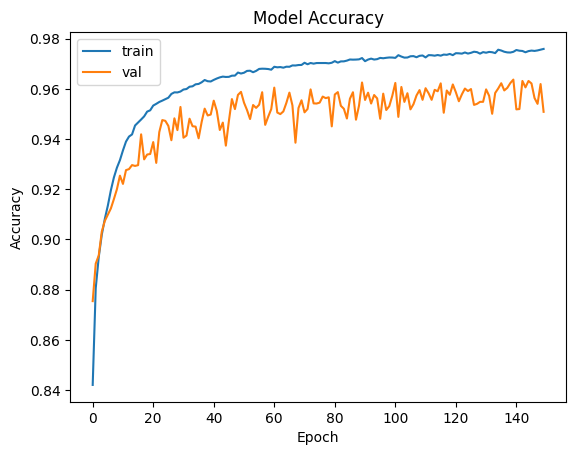

In [19]:
plt.plot(acc)
plt.plot(val_acc)

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

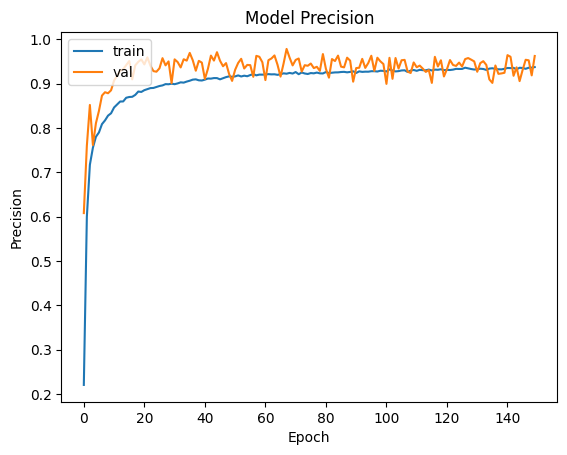

In [20]:
plt.plot(precision)
plt.plot(val_precision)

plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

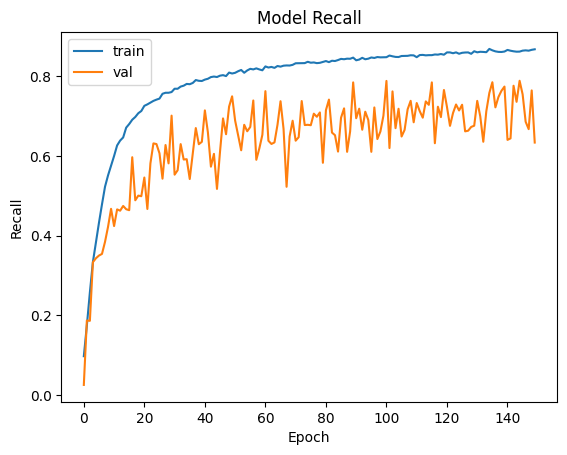

In [21]:
plt.plot(recall)
plt.plot(val_recall)

plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

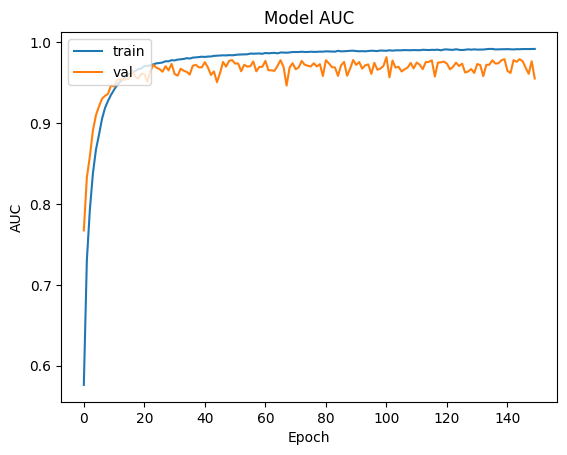

In [22]:
plt.plot(auc)
plt.plot(val_auc)

plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

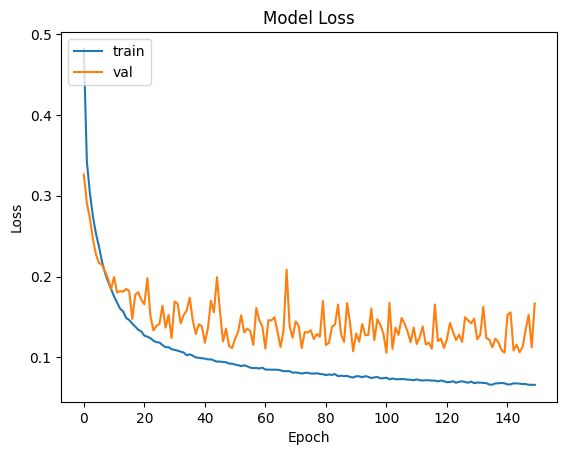

In [23]:
plt.plot(loss)
plt.plot(val_loss)

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Test Metrics

In [14]:
loss, acc, prec, rec, auc, fn, fp, tn, tp = mesonet_model.evaluate(test_dataset_cdfv2)

print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'AUC: {auc:.4f}')
print('--------------------')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')
print(f'True Negatives: {tn}')

521/521 [==============================] - 156s 288ms/step - loss: 0.5587 - binary_accuracy: 0.8605 - precision: 0.9880 - recall: 0.6127 - auc: 0.9367 - false_negatives: 2282.0000 - false_positives: 44.0000 - true_negatives: 10734.0000 - true_positives: 3610.0000
Loss: 0.5587
Accuracy: 0.8605
Precision: 0.9880
Recall: 0.6127
AUC: 0.9367
--------------------
False Positives: 44.0
False Negatives: 2282.0
True Positives: 3610.0
True Negatives: 10734.0


# Model Pruning

In [31]:
# Pruning only dense layers
# Helper function uses `prune_low_magnitude` to make only the 
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
    
    if isinstance(layer, keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    
    return layer

In [32]:
# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = keras.models.clone_model(
    mesonet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 256, 256, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                      

In [42]:
end_step = np.ceil(30585/32).astype(np.int32) * 20

In [43]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

pruned_model = tfmot.sparsity.keras.prune_low_magnitude(mesonet_model, **pruning_params)
pruned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d_  (None, 256, 256, 8)      442       
 4 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 256, 256, 8)      33        
 ormalization_4 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 128, 128, 8)      1         
 ling2d_4 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_conv2d_  (None, 128, 128, 8)      3210      
 5 (PruneLowMagnitude)                                

In [ ]:
#logdir = tempfile.mkdtemp()

#callbacks = [
 # tfmot.sparsity.keras.UpdatePruningStep(),
 # tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),]
  
#model_for_pruning.fit(train_images, train_labels,
#                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
#                 callbacks=callbacks)

In [ ]:
def setup_pretrained_weights(model, train_ds, val_ds):
    
    model.fit(train_ds, 
             max_epochs = 20,
             validation_data = val_ds,
             verbose = 1)
    _, pretrained_weights = tempfile.mkstemp('.tf')
    model.save_weights(pretrained_weights)
    return pretrained_weights

In [ ]:
#pretrained_weights = setup_pretrained_weights()
#model.load_weights(pretrained_weights)    ---> recommended for accuracy, can only do this once model is trained

# Test Video Scores

In [17]:
class VideoScore():
    def __init__(self, filename, score, true_class, fake_on_lower_half = True):
        self.filename = filename
        self.score = score
        self.true_class = true_class
        self.fake_on_lower_half = fake_on_lower_half

    def get_filename(self):
        return self.filename
    
    def get_score(self):
        return self.score
    
    def get_true_class(self):
        return self.true_class
    
    def get_fake_on_lower_half(self):
        return self.fake_on_lower_half

In [18]:
def get_video_score(model, fp):
    frames = extract_frames_from_video(fp)

    tf_frames = []
    for frame in frames:
        tf_frames.append(tf.convert_to_tensor(frame))

    tf_frames = tf.convert_to_tensor(tf_frames)
    results = model.predict(tf_frames, verbose=0)

    return np.average(results)

In [19]:
def get_test_scores(dataset, model):
    video_scores = []


    for class_dir in CLASS:
    
        vid_dir = dataset + DS_FACE + DS_TEST + class_dir
        for video in os.listdir(vid_dir):
            fp = vid_dir + video

            video_score = VideoScore(video, 
                                    get_video_score(model, fp),
                                    class_dir)
            
            video_scores.append(video_score)

    return video_scores

In [20]:
mesonet_test_scores = get_test_scores(DS_CDFV1, mesonet_model)


# with open(TEST_SCORE_PATH + 'mesonet_scores', 'wb') as f:
#     pickle.dump(mesonet_test_scores, f)


In [21]:
true_fake, true_real, false_fake, false_real = 0, 0, 0, 0

for vid_score in mesonet_test_scores:
    score = vid_score.get_score()
    if score < 0.5 and vid_score.get_true_class() == CLASS_FAKE:
        true_fake += 1

    elif score >= 0.5 and vid_score.get_true_class() == CLASS_REAL:
        true_real += 1

    elif score < 0.5 and vid_score.get_true_class() == CLASS_REAL:
        false_fake += 1

    else:
        false_real += 1


In [22]:
accuracy = (true_real + true_fake) / (true_fake + true_real + false_fake + false_real)

In [23]:
print(f'True Fake:{true_fake}')
print(f'True Real:{true_real}')
print(f'False Fake:{false_fake}')
print(f'False Real:{false_real}')
print(f'---')
print(f'Accuracy: {accuracy}')

True Fake:24
True Real:25
False Fake:13
False Real:38
---
Accuracy: 0.49
